In [ ]:
# pip install sktime
# pip install dtaidistance 
# pip install tslearn 

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sktime.transformations.series.paa import PAA
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
from sktime.utils.plotting import plot_series
from sklearn.metrics import silhouette_score
from sktime.clustering.k_means import TimeSeriesKMeans
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from tslearn.metrics import dtw
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_selection import VarianceThreshold
import itertools
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sktime.classification.kernel_based import RocketClassifier


In [1]:
def load_npy(filename):
    return np.load(filename)

In [2]:
dir_path = '/time_series/'
len_threshold = 1280


In [ ]:
X, y, ids = [], [], []

for file in os.listdir(dir_path):
    if os.path.splitext(file)[1] != '.npy':
        continue

    split = file.split("_")
    track_id = split[0]
    genre = split[1][:-4]  # Remove '.npy' extension
    ts = load_npy(os.path.join(dir_path, file))  # Load time series data
    
    # Check if the length of ts is strictly greater than len_threshold
    if len(ts) > len_threshold:
        print(f"Time series {file} is longer than len_threshold and will be cut.")
        ts = ts[:len_threshold]  # Trim ts to len_threshold
    elif len(ts) == len_threshold:
        pass  # Time series is exactly len_threshold, no need to print anything
    elif len_threshold - len(ts) < 20:
        pad = [np.mean(ts[:-5])] * (len_threshold-len(ts)) # fill by mean value of last n observations
        ts = np.append(ts, pad) 
        print(f"Time series {file} is a bit shorter than len_threshold, it was padded to len_threshold.")
    else: 
        print(f"Time series {file} is much shorter than len_threshold and will be skipped.")
        continue  # Skip this iteration if ts is shorter than len_threshold
    
    # Append data to X, y, and ids
    X.append([ts])
    y.append(genre)
    ids.append(track_id)

# Convert lists to numpy arrays
X, y, ids = np.array(X), np.array(y), np.array(ids)

#0DVMaexfdXDz19zUv1zKej_kids.npy was (830,)
#0P2DLw3xEcOgyYI7Ye4whM_honky-tonk.npy was (1263,)

In [5]:
X.shape, y.shape

((9999, 1, 1280), (9999,))

In [ ]:
# saved as npy files (for subsequent reloading)

# np.savez('X_y_ids', X, y, ids)

# reload
# X_y_ids = load_npy('X_y_ids.npz') 
# X, y, ids = X_y_ids['arr_0'], X_y_ids['arr_1'], X_y_ids['arr_2']

### 

### PAA Approximation

In [5]:
paa = PAA(frames=256)

X_paa = paa.fit_transform(X) 

In [6]:
X_paa.shape

(9999, 1, 256)

In [13]:
X_paa

array([[[4261.77123758, 4838.85294977, 4026.63489864, ...,
         4246.13311268, 4225.29011797, 3213.59759226]],

       [[1358.14295861, 1523.56178691, 1549.29388345, ...,
         1980.95161394, 1876.95242686, 3171.79429069]],

       [[ 636.91157363,  572.11560723,  630.72794741, ...,
          663.17853208,  642.04521045,  552.93177366]],

       ...,

       [[2401.72782961, 2475.6678935 , 2595.19295861, ...,
         2829.11536011, 1829.25163129, 2292.41888077]],

       [[ 287.3074921 ,  300.03265661,  308.67622308, ...,
          276.27543065,  286.08900089,  279.49782291]],

       [[ 343.12620164,  308.05757428,  307.27826196, ...,
          412.72997622,  320.79374502,  337.39649328]]])

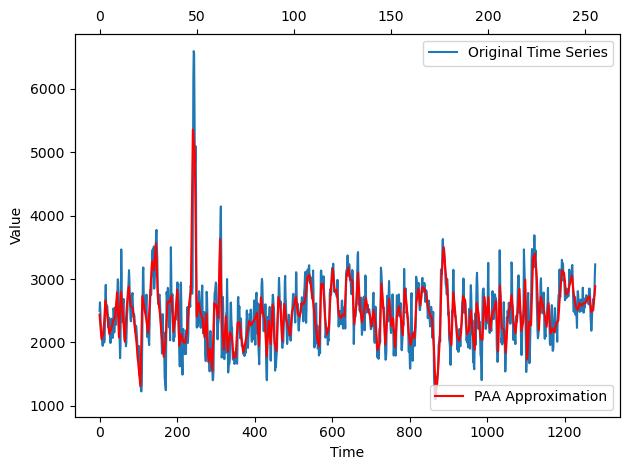

In [27]:
fig, ax1 = plt.subplots()

# Plot the original time series
ax1.plot(X[100][0], label="Original Time Series")

# Set labels and legend for the original time series
ax1.set_xlabel('Time')
ax1.set_ylabel('Value')
ax1.legend()

# Create a second y-axis for the PAA approximated time series
ax2 = ax1.twiny()

# Plot the PAA approximated time series
ax2.plot(X_paa[100][0], "r-", label="PAA Approximation")

# Set labels and legend for the PAA approximated time series
ax2.set_ylabel('PAA Value')
ax2.legend(loc='lower right')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [6]:
# Initialize MinMaxScaler (for Clustering)
scaler = MinMaxScaler()
time_series_data_reshaped = np.reshape(X_paa, (X_paa.shape[0], -1))

# Fit the scaler to your data and transform it
X_paa_minmax = scaler.fit_transform(time_series_data_reshaped)

# "The distance_matrix and distance_matrix_fast methods expect a list of lists/arrays" (following documentation)

In [7]:
# Initialize StandardScaler (for Classification)
scaler = StandardScaler()

# Fit the scaler to your data and transform it
X_paa_standard = scaler.fit_transform(time_series_data_reshaped)

In [8]:
## Compute DTW Distance Matrix for both both Standard Scaled and MinMax Scaled dataset, then save the .csv

In [10]:
distance_matrix_standard = dtw.distance_matrix_fast(X_paa_standard)

distance_df_standard = pd.DataFrame(distance_matrix_standard)

# Save the distance matrix DataFrame to a CSV file
distance_df_standard.to_csv('dtw_distance_matrix_standard.csv', index=False)

"from dtaidistance import dtw\nfrom dtaidistance import dtw_visualisation as dtwvis\n\ndistance_matrix_standard = dtw.distance_matrix_fast(X_paa_standard)\n\ndistance_df_standard = pd.DataFrame(distance_matrix_standard)\n\n# Save the distance matrix DataFrame to a CSV file\ndistance_df_standard.to_csv('dtw_distance_matrix_standard.csv', index=False)"

In [10]:
distance_matrix_minmax = dtw.distance_matrix_fast(X_paa_minmax)

distance_df_minmax = pd.DataFrame(distance_matrix_minmax)

# Save the distance matrix DataFrame to a CSV file
distance_df_minmax.to_csv('dtw_distance_matrix_minmax.csv', index=False)

In [ ]:
# for reloading purposes
# distance_df_minmax = pd.read_csv(r"C:\Users\rugge\Data Mining 2\dtw_distance_matrix_minmax.csv")
# distance_df_standard = pd.read_csv(r"C:\Users\rugge\Data Mining 2\dtw_distance_matrix_standard.csv")

In [11]:
distance_df_minmax

0         1         2         3         4         5         6  \
0     0.000000  2.262491  7.338395  1.893972  1.483052  3.657596  2.536053   
1     2.262491  0.000000  3.853635  1.541469  1.526603  1.753523  1.321811   
2     7.338395  3.853635  0.000000  4.249809  4.894212  2.045069  3.332471   
3     1.893972  1.541469  4.249809  0.000000  0.973997  1.853986  1.211701   
4     1.483052  1.526603  4.894212  0.973997  0.000000  2.002158  1.291512   
...        ...       ...       ...       ...       ...       ...       ...   
9994  1.952118  1.219753  3.978678  1.283801  1.270059  1.677751  1.202472   
9995  7.493908  4.162753  0.187828  4.467584  5.174062  2.258799  3.645324   
9996  1.751284  1.425316  3.874048  0.827393  1.027928  1.530585  1.098333   
9997  8.099253  5.149363  0.678740  5.078272  5.826121  3.152044  4.589652   
9998  8.100265  5.114989  0.630177  5.080633  5.824956  3.105583  4.548988   

             7         8         9  ...      9989      9990      9991  \
0     2.853265  2.037140  3.008386  ...  3.534589  3.815348  1.813220   
1     1.612554  1.501578  1.619258  ...  1.749216  1.840159  1.328683   
2     2.228050  4.049913  3.545004  ...  2.120171  1.423759  4.336065   
3     1.357833  1.160591  2.085936  ...  1.157017  1.480472  0.801618   
4     1.458727  1.158843  1.966828  ...  1.588890  1.799080  0.919485   
...        ...       ...       ...  ...       ...       ...       ...   
9994  1.459508  1.187629  1.683816  ...  1.553210  1.671052  1.148659   
9995  2.428858  4.337357  3.749569  ...  2.346341  1.670385  4.562066   
9996  1.079233  0.967574  1.698493  ...  1.170504  1.219522  0.887397   
9997  3.423307  5.194734  4.569681  ...  3.249491  2.624813  5.442828   
9998  3.386608  5.193487  4.523637  ...  3.253390  2.565454  5.401411   

          9992      9993      9994      9995      9996      9997      9998  
0     2.118160  1.918048  1.952118  7.493908  1.751284  8.099253  8.100265  
1     1.601294  1.430970  1.219753  4.162753  1.425316  5.149363  5.114989  
2     4.756504  4.637913  3.978678  0.187828  3.874048  0.678740  0.630177  
3     1.559151  1.596778  1.283801  4.467584  0.827393  5.078272  5.080633  
4     1.428117  1.349096  1.270059  5.174062  1.027928  5.826121  5.824956  
...        ...       ...       ...       ...       ...       ...       ...  
9994  1.332482  1.339652  0.000000  4.288452  1.115403  5.227524  5.190541  
9995  4.878762  5.001708  4.288452  0.000000  4.073189  0.520108  0.468870  
9996  1.194091  1.414940  1.115403  4.073189  0.000000  4.921920  4.909122  
9997  5.635145  5.912377  5.227524  0.520108  4.921920  0.000000  0.053193  
9998  5.545409  5.828306  5.190541  0.468870  4.909122  0.053193  0.000000  

[9999 rows x 9999 columns]

In [12]:
distance_df_standard

0          1          2          3          4          5  \
0      0.000000  16.178222  53.603383  15.186858  11.224682  28.412407   
1     16.178222   0.000000  28.931515  11.542893  11.305571  12.772659   
2     53.603383  28.931515   0.000000  31.395089  36.594023  15.438572   
3     15.186858  11.542893  31.395089   0.000000   6.813890  13.835347   
4     11.224682  11.305571  36.594023   6.813890   0.000000  15.448462   
...         ...        ...        ...        ...        ...        ...   
9994  14.244469   8.887185  30.294643   9.525016   9.335679  12.312302   
9995  54.728168  29.062214   1.182566  32.560582  37.839784  15.729186   
9996  12.394637  10.629128  28.743554   5.782999   7.151824  11.785113   
9997  59.098886  36.102749   3.789767  36.907349  42.191557  21.690286   
9998  59.103035  35.829238   3.420290  36.917539  42.177421  21.339078   

              6          7          8          9  ...       9989       9990  \
0     18.480362  21.528389  14.335052  21.677298  ...  27.322108  27.054977   
1      9.607793  11.627006  10.974449  11.724334  ...  12.770204  13.146315   
2     25.525190  16.995648  30.793010  26.455351  ...  16.236936  10.852957   
3      8.492120  10.592782   8.338587  15.181187  ...  10.114500  11.710398   
4      9.433965  11.274815   7.727556  14.856686  ...  12.591489  14.813888   
...         ...        ...        ...        ...  ...        ...        ...   
9994   8.920116  10.662657   8.777721  11.976436  ...  11.421822  12.083756   
9995  27.101941  16.986102  32.007092  26.756410  ...  16.558931  11.512096   
9996   7.880307   7.840834   6.634950  12.445769  ...   9.531547   8.888780   
9997  33.384234  23.720088  37.708252  32.145118  ...  23.269781  18.220162   
9998  33.406500  23.337176  37.724802  31.770339  ...  23.126510  18.017124   

           9991       9992       9993       9994       9995       9996  \
0     13.096150  15.924854  14.168863  14.244469  54.728168  12.394637   
1      9.733399  11.616897  10.264976   8.887185  29.062214  10.629128   
2     32.362922  34.773357  34.532222  30.294643   1.182566  28.743554   
3      5.670407  11.704217  11.878205   9.525016  32.560582   5.782999   
4      6.342400  10.788056   9.535394   9.335679  37.839784   7.151824   
...         ...        ...        ...        ...        ...        ...   
9994   8.287742   9.567003   9.400899   0.000000  30.562984   8.364947   
9995  33.072185  35.119249  35.816581  30.562984   0.000000  29.236387   
9996   6.070380   8.897329  10.144921   8.364947  29.236387   0.000000   
9997  39.608944  40.886593  43.202032  37.596572   3.154930  35.682399   
9998  39.556070  40.143235  42.758555  37.389777   2.658521  35.583113   

           9997       9998  
0     59.098886  59.103035  
1     36.102749  35.829238  
2      3.789767   3.420290  
3     36.907349  36.917539  
4     42.191557  42.177421  
...         ...        ...  
9994  37.596572  37.389777  
9995   3.154930   2.658521  
9996  35.682399  35.583113  
9997   0.000000   0.364755  
9998   0.364755   0.000000  

[9999 rows x 9999 columns]

In [13]:
X_paa_minmax.shape

(9999, 256)

# Clustering

### Euclidean K-Means, K=7

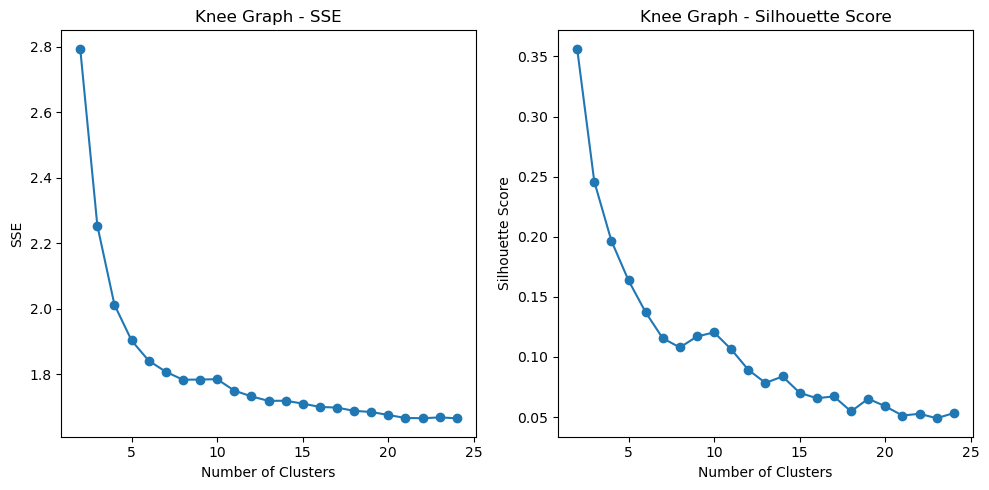

In [20]:
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import silhouette_score


num_samples, num_features = X_paa_minmax.shape

# Define a range of cluster numbers to evaluate
cluster_range = range(2, 25)  # Example range from 2 to 25 clusters

# Initialize lists to store SSE and Silhouette scores
sse_scores = []
silhouette_scores = []

# Fit clustering algorithm with different numbers of clusters and compute metrics
for n_clusters in cluster_range:
    clusterer = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean")
    clusterer.fit(X_paa_minmax)  # Assuming X_train contains your time series data
    
    # Compute SSE (Sum of Squared Errors)
    sse = clusterer.inertia_
    sse_scores.append(sse)
    
    # Compute Silhouette score
    labels = clusterer.labels_
    silhouette = silhouette_score(X_paa_minmax, labels, metric='euclidean')
    silhouette_scores.append(silhouette)

# Plot the Knee Graph
plt.figure(figsize=(10, 5))

# Plot SSE
plt.subplot(1, 2, 1)
plt.plot(cluster_range, sse_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Knee Graph - SSE')

# Plot Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Knee Graph - Silhouette Score')

plt.tight_layout()
plt.show()


In [36]:
clusterer = TimeSeriesKMeans(n_clusters=7, metric="euclidean")

In [37]:
%%time
clusterer.fit(X_paa_minmax)

CPU times: total: 22.3 s
Wall time: 35.1 s


TimeSeriesKMeans(metric='euclidean', n_clusters=7)

In [18]:
X_paa_minmax_df = pd.DataFrame(np.squeeze(X_paa_minmax))

In [39]:
X_paa_minmax_df['euclidean_kmeans_clusterlabels'] = clusterer.labels_
X_paa_minmax_df.head()

0         1         2         3         4         5         6  \
0  0.550581  0.722783  0.627673  0.689854  0.652698  0.631544  0.615292   
1  0.175459  0.227576  0.241504  0.488904  0.216017  0.188225  0.236811   
2  0.082283  0.085457  0.098318  0.091286  0.104032  0.097868  0.097638   
3  0.322408  0.354741  0.389081  0.327479  0.364604  0.384191  0.371945   
4  0.290143  0.311800  0.322076  0.297566  0.348094  0.359502  0.355234   

          7         8         9  ...       247       248       249       250  \
0  0.726110  0.659458  0.481611  ...  0.612869  0.523568  0.591813  0.577445   
1  0.675469  0.429559  0.322083  ...  0.434799  0.256235  0.354488  0.301844   
2  0.112455  0.104285  0.095756  ...  0.085195  0.076104  0.077025  0.084265   
3  0.503513  0.524796  0.341106  ...  0.354120  0.363922  0.354058  0.341959   
4  0.336806  0.369680  0.451999  ...  0.482730  0.454059  0.341132  0.327842   

        251       252       253       254       255  \
0  0.501389  0.463417  0.613967  0.585155  0.440428   
1  0.546893  0.527891  0.286434  0.259937  0.434699   
2  0.081024  0.085843  0.095892  0.088916  0.075780   
3  0.284293  0.297615  0.337532  0.339932  0.332982   
4  0.406029  0.354772  0.326374  0.286968  0.325253   

   euclidean_kmeans_clusterlabels  
0                               6  
1                               5  
2                               3  
3                               2  
4                               2  

[5 rows x 257 columns]

C:\Users\rugge\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\rugge\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


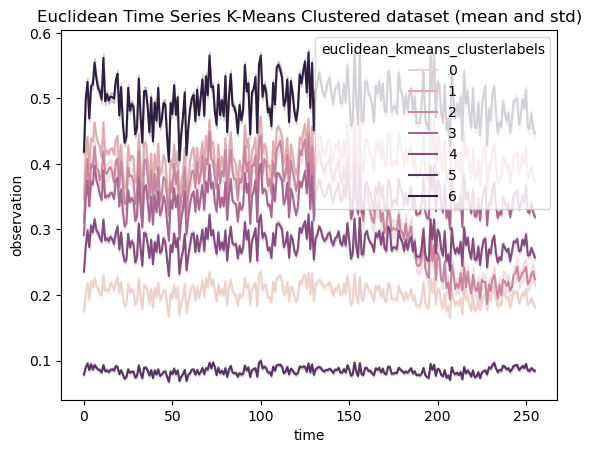

In [21]:
df_melt = X_paa_minmax_df.melt(value_name="observation", var_name="time", id_vars="euclidean_kmeans_clusterlabels")
sns.lineplot(data=df_melt, x="time", y="observation", hue="euclidean_kmeans_clusterlabels")
plt.title("Euclidean Time Series K-Means Clustered dataset (mean and std)")
plt.show()

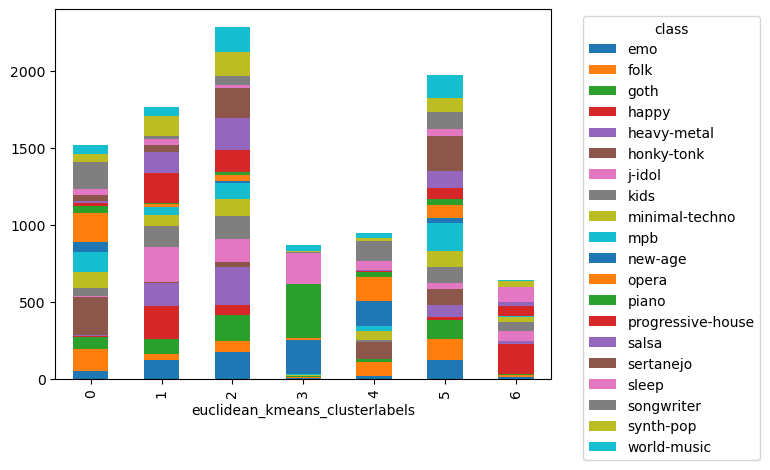

In [83]:
ax = pd.crosstab(X_paa_minmax_df["euclidean_kmeans_clusterlabels"], y).plot(kind="bar", stacked=True)
plt.legend(title="class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Cluster 3 and 6 seem only "discriminative" clusters


In [75]:
# Genres in Cluster 6

# Filter the DataFrame where 'euclidean_kmeans_clusterlabels' == 6
minmax_filtered_df = X_paa_minmax_df[X_paa_minmax_df['euclidean_kmeans_clusterlabels'] == 6]

# Get the indices of the filtered DataFrame
filtered_indices = minmax_filtered_df.index

# Filter y based on the indices
y_filtered = y[filtered_indices]

# Convert y_filtered to a pandas Series
y_series = pd.Series(y_filtered, index=filtered_indices)

# Count the occurrences of each genre in the filtered DataFrame based on y
count_values = y_series.value_counts()

print('Cluster6:\n')
count_values

### "happy" and "sleep" as top-2 most frequent genres is not what was expected

Cluster6:



happy                197
sleep                 92
j-idol                68
progressive-house     66
kids                  53
synth-pop             42
minimal-techno        36
salsa                 27
heavy-metal           16
emo                   12
folk                  11
goth                   8
mpb                    5
world-music            4
new-age                1
honky-tonk             1
Name: count, dtype: int64

In [84]:
# Genres in Cluster 3

# Filter the DataFrame where 'euclidean_kmeans_clusterlabels' == 3
minmax_filtered_df = X_paa_minmax_df[X_paa_minmax_df['euclidean_kmeans_clusterlabels'] == 3]

# Get the indices of the filtered DataFrame
filtered_indices = minmax_filtered_df.index

# Filter y based on the indices
y_filtered = y[filtered_indices]

# Convert y_filtered to a pandas Series
y_series = pd.Series(y_filtered, index=filtered_indices)

# Count the occurrences of each genre in the filtered DataFrame based on y
count_values = y_series.value_counts()

print('Cluster3:\n')
count_values

### It comprises mainly slow songs

Cluster3:



piano             350
new-age           223
sleep             197
world-music        39
opera              16
songwriter         11
folk               10
minimal-techno      9
emo                 4
synth-pop           3
goth                2
honky-tonk          2
mpb                 1
Name: count, dtype: int64

### Euclidean K-Means, K=3 (Best configuration)

In [9]:
clusterer = TimeSeriesKMeans(n_clusters=3, metric="euclidean")

In [10]:
%%time
clusterer.fit(X_paa_minmax)

CPU times: total: 21 s
Wall time: 42.1 s


TimeSeriesKMeans()

In [17]:
# Create a DataFrame from the flattened arrays
X_paa_minmax_df_labels = pd.DataFrame(np.squeeze(X_paa_minmax))

# Add other columns
X_paa_minmax_df_labels['cluster_labels'] = clusterer.labels_
X_paa_minmax_df_labels['id'] = ids
X_paa_minmax_df_labels['genres'] = y

# Save DataFrame as CSV
X_paa_minmax_df_labels.to_csv('TimeSeriesKMeansLabels.csv', index=False)

In [18]:
X_paa_minmax_df_labels

0         1         2         3         4         5         6  \
0     0.550581  0.722783  0.627673  0.689854  0.652698  0.631544  0.615292   
1     0.175459  0.227576  0.241504  0.488904  0.216017  0.188225  0.236811   
2     0.082283  0.085457  0.098318  0.091286  0.104032  0.097868  0.097638   
3     0.322408  0.354741  0.389081  0.327479  0.364604  0.384191  0.371945   
4     0.290143  0.311800  0.322076  0.297566  0.348094  0.359502  0.355234   
...        ...       ...       ...       ...       ...       ...       ...   
9994  0.251427  0.251764  0.325232  0.363410  0.442349  0.531584  0.510902   
9995  0.080699  0.091974  0.080538  0.063147  0.067098  0.060476  0.065211   
9996  0.310281  0.369792  0.404539  0.390989  0.412862  0.421278  0.553811   
9997  0.037117  0.044816  0.048117  0.044514  0.048364  0.035570  0.041894   
9998  0.044329  0.046015  0.047899  0.042932  0.051065  0.038442  0.043066   

             7         8         9  ...       249       250       251  \
0     0.726110  0.659458  0.481611  ...  0.591813  0.577445  0.501389   
1     0.675469  0.429559  0.322083  ...  0.354488  0.301844  0.546893   
2     0.112455  0.104285  0.095756  ...  0.077025  0.084265  0.081024   
3     0.503513  0.524796  0.341106  ...  0.354058  0.341959  0.284293   
4     0.336806  0.369680  0.451999  ...  0.341132  0.327842  0.406029   
...        ...       ...       ...  ...       ...       ...       ...   
9994  0.398810  0.320989  0.225233  ...  0.304160  0.374736  0.263660   
9995  0.074435  0.096669  0.080065  ...  0.096404  0.096425  0.082672   
9996  0.583704  0.443595  0.458752  ...  0.394629  0.231084  0.429881   
9997  0.040647  0.040644  0.041046  ...  0.043209  0.045258  0.040643   
9998  0.035473  0.034661  0.037693  ...  0.051963  0.055225  0.050485   

           252       253       254       255  cluster_labels  \
0     0.463417  0.613967  0.585155  0.440428               0   
1     0.527891  0.286434  0.259937  0.434699               1   
2     0.085843  0.095892  0.088916  0.075780               2   
3     0.297615  0.337532  0.339932  0.332982               0   
4     0.354772  0.326374  0.286968  0.325253               0   
...        ...       ...       ...       ...             ...   
9994  0.558302  0.471825  0.372510  0.359233               1   
9995  0.091868  0.083870  0.075174  0.076859               2   
9996  0.481935  0.409074  0.253331  0.314179               1   
9997  0.037789  0.039948  0.039620  0.038306               2   
9998  0.051992  0.059678  0.044426  0.046241               2   

                          id             genres  
0     002qpSULhHAw6DGqFxbaO1              happy  
1     004h8smbIoAkUNDJvVKwkG                emo  
2     006ATYzgynEKIPgVaT5LQM        world-music  
3     00C93bsNIjHStKvr1lPJee        heavy-metal  
4     00CsDW3I9XueUvaXnAvGMm  progressive-house  
...                      ...                ...  
9994  7zmbtfKgZMTQ1GlqBno5T5          synth-pop  
9995  7zP20CANb26S52imHKKWEc              piano  
9996  7zvGj5jjRIBRqT82crTMVf        world-music  
9997  7zwddyEol0Hg5K8HQd3srX              sleep  
9998  7zwWkmiQaVt3AFXUnhBlZk              sleep  

[9999 rows x 259 columns]

In [68]:
X_paa_minmax_df2 = X_paa_minmax_df
X_paa_minmax_df2['euclidean_kmeans_clusterlabels2'] = clusterer.labels_

In [76]:
X_paa_minmax_df2 = X_paa_minmax_df2.iloc[:,:257]

In [78]:
X_paa_minmax_df2

0         1         2         3         4         5         6  \
0     0.550581  0.722783  0.627673  0.689854  0.652698  0.631544  0.615292   
1     0.175459  0.227576  0.241504  0.488904  0.216017  0.188225  0.236811   
2     0.082283  0.085457  0.098318  0.091286  0.104032  0.097868  0.097638   
3     0.322408  0.354741  0.389081  0.327479  0.364604  0.384191  0.371945   
4     0.290143  0.311800  0.322076  0.297566  0.348094  0.359502  0.355234   
...        ...       ...       ...       ...       ...       ...       ...   
9994  0.251427  0.251764  0.325232  0.363410  0.442349  0.531584  0.510902   
9995  0.080699  0.091974  0.080538  0.063147  0.067098  0.060476  0.065211   
9996  0.310281  0.369792  0.404539  0.390989  0.412862  0.421278  0.553811   
9997  0.037117  0.044816  0.048117  0.044514  0.048364  0.035570  0.041894   
9998  0.044329  0.046015  0.047899  0.042932  0.051065  0.038442  0.043066   

             7         8         9  ...       247       248       249  \
0     0.726110  0.659458  0.481611  ...  0.612869  0.523568  0.591813   
1     0.675469  0.429559  0.322083  ...  0.434799  0.256235  0.354488   
2     0.112455  0.104285  0.095756  ...  0.085195  0.076104  0.077025   
3     0.503513  0.524796  0.341106  ...  0.354120  0.363922  0.354058   
4     0.336806  0.369680  0.451999  ...  0.482730  0.454059  0.341132   
...        ...       ...       ...  ...       ...       ...       ...   
9994  0.398810  0.320989  0.225233  ...  0.357952  0.277415  0.304160   
9995  0.074435  0.096669  0.080065  ...  0.105118  0.114495  0.096404   
9996  0.583704  0.443595  0.458752  ...  0.327571  0.435499  0.394629   
9997  0.040647  0.040644  0.041046  ...  0.037924  0.041330  0.043209   
9998  0.035473  0.034661  0.037693  ...  0.057266  0.051361  0.051963   

           250       251       252       253       254       255  \
0     0.577445  0.501389  0.463417  0.613967  0.585155  0.440428   
1     0.301844  0.546893  0.527891  0.286434  0.259937  0.434699   
2     0.084265  0.081024  0.085843  0.095892  0.088916  0.075780   
3     0.341959  0.284293  0.297615  0.337532  0.339932  0.332982   
4     0.327842  0.406029  0.354772  0.326374  0.286968  0.325253   
...        ...       ...       ...       ...       ...       ...   
9994  0.374736  0.263660  0.558302  0.471825  0.372510  0.359233   
9995  0.096425  0.082672  0.091868  0.083870  0.075174  0.076859   
9996  0.231084  0.429881  0.481935  0.409074  0.253331  0.314179   
9997  0.045258  0.040643  0.037789  0.039948  0.039620  0.038306   
9998  0.055225  0.050485  0.051992  0.059678  0.044426  0.046241   

      euclidean_kmeans_clusterlabels2  
0                                   0  
1                                   2  
2                                   1  
3                                   0  
4                                   0  
...                               ...  
9994                                2  
9995                                1  
9996                                2  
9997                                1  
9998                                1  

[9999 rows x 257 columns]

C:\Users\rugge\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\rugge\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


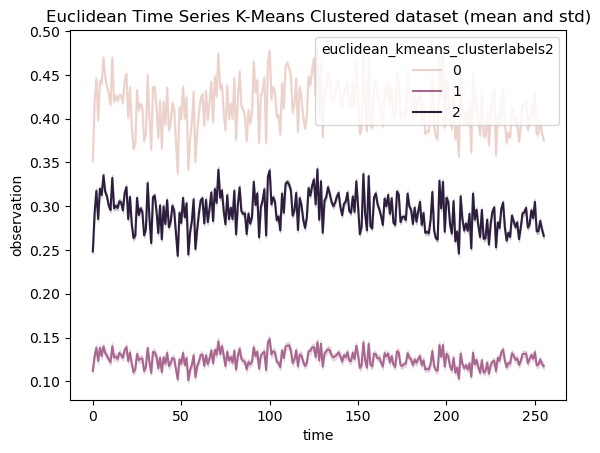

In [79]:
df_melt = X_paa_minmax_df2.melt(value_name="observation", var_name="time", id_vars="euclidean_kmeans_clusterlabels2")
sns.lineplot(data=df_melt, x="time", y="observation", hue="euclidean_kmeans_clusterlabels2")
plt.title("Euclidean Time Series K-Means Clustered dataset (mean and std)")
plt.show()

In [192]:
silhouette_avg = silhouette_score(X_paa_minmax_df2.iloc[:,:256], X_paa_minmax_df2["euclidean_kmeans_clusterlabels2"])

# Print the silhouette score
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.24533020083950308


In [191]:
X_paa_minmax_df2.iloc[:,:256]

0         1         2         3         4         5         6    \
0     0.550581  0.722783  0.627673  0.689854  0.652698  0.631544  0.615292   
1     0.175459  0.227576  0.241504  0.488904  0.216017  0.188225  0.236811   
2     0.082283  0.085457  0.098318  0.091286  0.104032  0.097868  0.097638   
3     0.322408  0.354741  0.389081  0.327479  0.364604  0.384191  0.371945   
4     0.290143  0.311800  0.322076  0.297566  0.348094  0.359502  0.355234   
...        ...       ...       ...       ...       ...       ...       ...   
9994  0.251427  0.251764  0.325232  0.363410  0.442349  0.531584  0.510902   
9995  0.080699  0.091974  0.080538  0.063147  0.067098  0.060476  0.065211   
9996  0.310281  0.369792  0.404539  0.390989  0.412862  0.421278  0.553811   
9997  0.037117  0.044816  0.048117  0.044514  0.048364  0.035570  0.041894   
9998  0.044329  0.046015  0.047899  0.042932  0.051065  0.038442  0.043066   

           7         8         9    ...       246       247       248  \
0     0.726110  0.659458  0.481611  ...  0.554288  0.612869  0.523568   
1     0.675469  0.429559  0.322083  ...  0.183092  0.434799  0.256235   
2     0.112455  0.104285  0.095756  ...  0.071856  0.085195  0.076104   
3     0.503513  0.524796  0.341106  ...  0.326876  0.354120  0.363922   
4     0.336806  0.369680  0.451999  ...  0.370813  0.482730  0.454059   
...        ...       ...       ...  ...       ...       ...       ...   
9994  0.398810  0.320989  0.225233  ...  0.203238  0.357952  0.277415   
9995  0.074435  0.096669  0.080065  ...  0.105538  0.105118  0.114495   
9996  0.583704  0.443595  0.458752  ...  0.466567  0.327571  0.435499   
9997  0.040647  0.040644  0.041046  ...  0.038820  0.037924  0.041330   
9998  0.035473  0.034661  0.037693  ...  0.046194  0.057266  0.051361   

           249       250       251       252       253       254       255  
0     0.591813  0.577445  0.501389  0.463417  0.613967  0.585155  0.440428  
1     0.354488  0.301844  0.546893  0.527891  0.286434  0.259937  0.434699  
2     0.077025  0.084265  0.081024  0.085843  0.095892  0.088916  0.075780  
3     0.354058  0.341959  0.284293  0.297615  0.337532  0.339932  0.332982  
4     0.341132  0.327842  0.406029  0.354772  0.326374  0.286968  0.325253  
...        ...       ...       ...       ...       ...       ...       ...  
9994  0.304160  0.374736  0.263660  0.558302  0.471825  0.372510  0.359233  
9995  0.096404  0.096425  0.082672  0.091868  0.083870  0.075174  0.076859  
9996  0.394629  0.231084  0.429881  0.481935  0.409074  0.253331  0.314179  
9997  0.043209  0.045258  0.040643  0.037789  0.039948  0.039620  0.038306  
9998  0.051963  0.055225  0.050485  0.051992  0.059678  0.044426  0.046241  

[9999 rows x 256 columns]

In [189]:
X_paa_minmax_df2

0         1         2         3         4         5         6  \
0     0.550581  0.722783  0.627673  0.689854  0.652698  0.631544  0.615292   
1     0.175459  0.227576  0.241504  0.488904  0.216017  0.188225  0.236811   
2     0.082283  0.085457  0.098318  0.091286  0.104032  0.097868  0.097638   
3     0.322408  0.354741  0.389081  0.327479  0.364604  0.384191  0.371945   
4     0.290143  0.311800  0.322076  0.297566  0.348094  0.359502  0.355234   
...        ...       ...       ...       ...       ...       ...       ...   
9994  0.251427  0.251764  0.325232  0.363410  0.442349  0.531584  0.510902   
9995  0.080699  0.091974  0.080538  0.063147  0.067098  0.060476  0.065211   
9996  0.310281  0.369792  0.404539  0.390989  0.412862  0.421278  0.553811   
9997  0.037117  0.044816  0.048117  0.044514  0.048364  0.035570  0.041894   
9998  0.044329  0.046015  0.047899  0.042932  0.051065  0.038442  0.043066   

             7         8         9  ...       248       249       250  \
0     0.726110  0.659458  0.481611  ...  0.523568  0.591813  0.577445   
1     0.675469  0.429559  0.322083  ...  0.256235  0.354488  0.301844   
2     0.112455  0.104285  0.095756  ...  0.076104  0.077025  0.084265   
3     0.503513  0.524796  0.341106  ...  0.363922  0.354058  0.341959   
4     0.336806  0.369680  0.451999  ...  0.454059  0.341132  0.327842   
...        ...       ...       ...  ...       ...       ...       ...   
9994  0.398810  0.320989  0.225233  ...  0.277415  0.304160  0.374736   
9995  0.074435  0.096669  0.080065  ...  0.114495  0.096404  0.096425   
9996  0.583704  0.443595  0.458752  ...  0.435499  0.394629  0.231084   
9997  0.040647  0.040644  0.041046  ...  0.041330  0.043209  0.045258   
9998  0.035473  0.034661  0.037693  ...  0.051361  0.051963  0.055225   

           251       252       253       254       255  \
0     0.501389  0.463417  0.613967  0.585155  0.440428   
1     0.546893  0.527891  0.286434  0.259937  0.434699   
2     0.081024  0.085843  0.095892  0.088916  0.075780   
3     0.284293  0.297615  0.337532  0.339932  0.332982   
4     0.406029  0.354772  0.326374  0.286968  0.325253   
...        ...       ...       ...       ...       ...   
9994  0.263660  0.558302  0.471825  0.372510  0.359233   
9995  0.082672  0.091868  0.083870  0.075174  0.076859   
9996  0.429881  0.481935  0.409074  0.253331  0.314179   
9997  0.040643  0.037789  0.039948  0.039620  0.038306   
9998  0.050485  0.051992  0.059678  0.044426  0.046241   

      euclidean_kmeans_clusterlabels2                      id  
0                                   0  002qpSULhHAw6DGqFxbaO1  
1                                   2  004h8smbIoAkUNDJvVKwkG  
2                                   1  006ATYzgynEKIPgVaT5LQM  
3                                   0  00C93bsNIjHStKvr1lPJee  
4                                   0  00CsDW3I9XueUvaXnAvGMm  
...                               ...                     ...  
9994                                2  7zmbtfKgZMTQ1GlqBno5T5  
9995                                1  7zP20CANb26S52imHKKWEc  
9996                                2  7zvGj5jjRIBRqT82crTMVf  
9997                                1  7zwddyEol0Hg5K8HQd3srX  
9998                                1  7zwWkmiQaVt3AFXUnhBlZk  

[9999 rows x 258 columns]

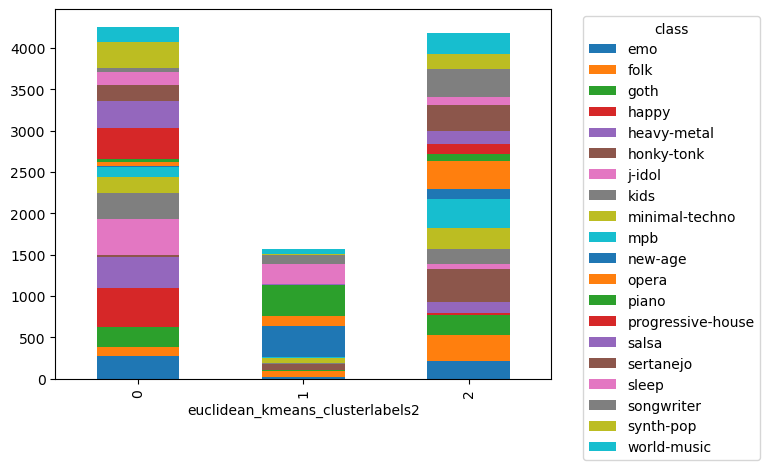

In [80]:
ax = pd.crosstab(X_paa_minmax_df2["euclidean_kmeans_clusterlabels2"], y).plot(kind="bar", stacked=True)
plt.legend(title="class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [81]:
# Cluster 0 insights

# Filter the DataFrame where 'euclidean_kmeans_clusterlabels' == 0
minmax_filtered_df2 = X_paa_minmax_df2[X_paa_minmax_df2['euclidean_kmeans_clusterlabels2'] == 0]

# Get the indices of the filtered DataFrame
filtered_indices = minmax_filtered_df2.index

# Filter y based on the indices
y_filtered = y[filtered_indices]

# Convert y_filtered to a pandas Series
y_series = pd.Series(y_filtered, index=filtered_indices)

# Count the occurrences of each genre in the filtered DataFrame based on y
count_values = y_series.value_counts()

print('Cluster0:\n')
count_values

### Comprises mainly active genres

Cluster0:



happy                468
j-idol               431
progressive-house    378
heavy-metal          375
salsa                335
kids                 312
synth-pop            309
emo                  277
goth                 243
minimal-techno       196
sertanejo            189
world-music          187
sleep                152
mpb                  128
folk                 103
songwriter            56
opera                 44
piano                 32
honky-tonk            31
new-age               10
Name: count, dtype: int64

In [82]:
# Cluster 1 insights

# Filter the DataFrame where 'euclidean_kmeans_clusterlabels' == 1
minmax_filtered_df2 = X_paa_minmax_df2[X_paa_minmax_df2['euclidean_kmeans_clusterlabels2'] == 1]

# Get the indices of the filtered DataFrame
filtered_indices = minmax_filtered_df2.index

# Filter y based on the indices
y_filtered = y[filtered_indices]

# Convert y_filtered to a pandas Series
y_series = pd.Series(y_filtered, index=filtered_indices)

# Count the occurrences of each genre in the filtered DataFrame based on y
count_values = y_series.value_counts()

print('Cluster1:\n')
count_values

### Comprises mainly slow genres


Cluster1:



piano                383
new-age              369
sleep                242
opera                119
songwriter           107
folk                  81
honky-tonk            73
world-music           65
minimal-techno        58
mpb                   17
goth                  15
emo                   14
synth-pop             12
kids                   6
salsa                  5
sertanejo              1
progressive-house      1
Name: count, dtype: int64

### Visualization with Dimensionality Reduction techniques 

#### PCA

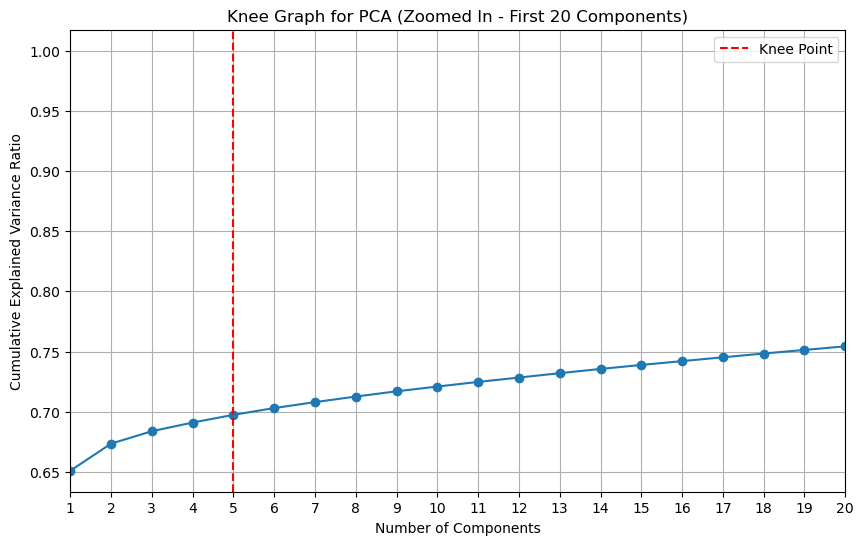

In [127]:
# Perform PCA to determine the explained variance ratio
pca = PCA()
pca.fit(X_paa_minmax)

# Calculate cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plot the knee graph zoomed into the first 20 components
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Knee Graph for PCA (Zoomed In - First 20 Components)')

# Add a vertical line to indicate the "knee"
plt.axvline(x=5, color='r', linestyle='--', label='Knee Point')
plt.legend()

plt.xlim(1, 20)  # Limit x-axis to first 20 components
plt.xticks(np.arange(1, 21, step=1))  # Set x-axis ticks for visibility

plt.grid(True)
plt.show()


In [33]:
# Perform PCA with 10 components
pca = PCA(n_components=5)
pca_components = pca.fit_transform(X_paa_minmax)

# Create a DataFrame with PCA components
pca_df = pd.DataFrame(data=pca_components, columns=[f'PC{i+1}' for i in range(5)])

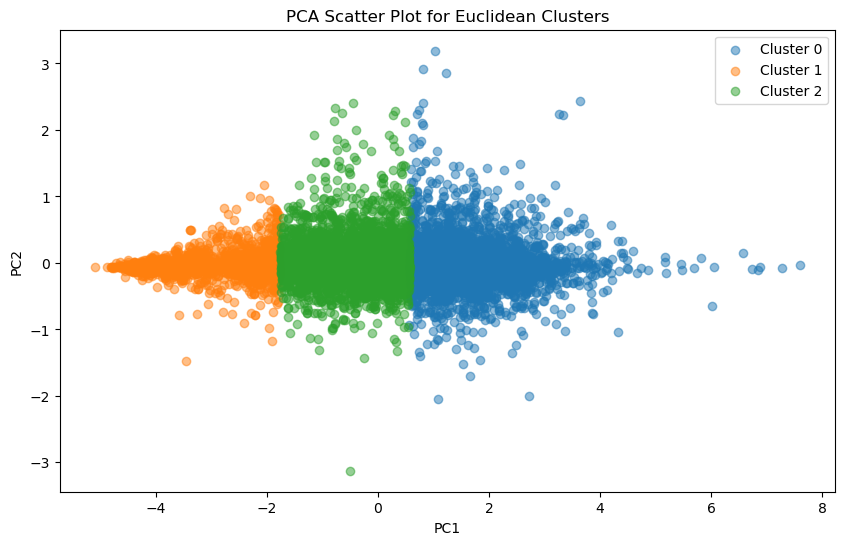

In [130]:
pca_df['euclidean_cluster_labels'] = X_paa_minmax_df2['euclidean_kmeans_clusterlabels2'].values

# Plot PCA scatter plot for Euclidean clusters
plt.figure(figsize=(10, 6))
for label in np.unique(pca_df['euclidean_cluster_labels']):
    plt.scatter(pca_df.loc[pca_df['euclidean_cluster_labels'] == label, 'PC1'],
                pca_df.loc[pca_df['euclidean_cluster_labels'] == label, 'PC2'],
                label=f'Cluster {label}', alpha=0.5)
plt.title('PCA Scatter Plot for Euclidean Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()


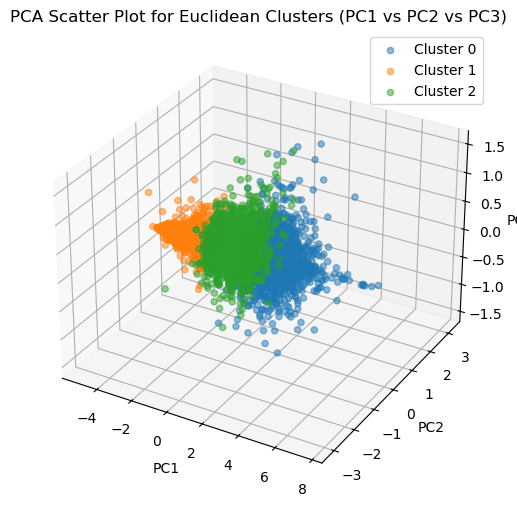

In [131]:
# Plot PCA scatter plot for Euclidean clusters in 3D
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

for label in np.unique(pca_df['euclidean_cluster_labels']):
    ax.scatter(pca_df.loc[pca_df['euclidean_cluster_labels'] == label, 'PC1'],
               pca_df.loc[pca_df['euclidean_cluster_labels'] == label, 'PC2'],
               pca_df.loc[pca_df['euclidean_cluster_labels'] == label, 'PC3'],
               label=f'Cluster {label}', alpha=0.5)

ax.set_title('PCA Scatter Plot for Euclidean Clusters (PC1 vs PC2 vs PC3)')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()

plt.show()


#### Variance Threshold

In [133]:
np.histogram(np.var(X_paa_minmax, axis=0)[np.var(X_paa_minmax, axis=0) < 3.14e04])

(array([ 4,  8, 20, 40, 52, 51, 41, 25,  7,  8], dtype=int64),
 array([0.01242828, 0.01370584, 0.01498341, 0.01626097, 0.01753853,
        0.0188161 , 0.02009366, 0.02137122, 0.02264879, 0.02392635,
        0.02520392]))

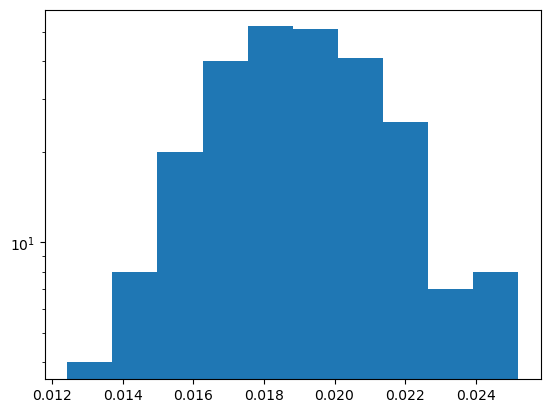

In [134]:
plt.hist(np.var(X_paa_minmax, axis=0)[np.var(X_paa_minmax, axis=0) < 3.14e04])
plt.yscale('log')
plt.show()

In [143]:
# Calculate mean and standard deviation of variances
mean_variance = np.mean(np.var(X_paa_minmax, axis=0))
std_variance = np.std(np.var(X_paa_minmax, axis=0))

# Choose threshold based on a multiple of standard deviation away from the mean
threshold = mean_variance + 2 * std_variance  # Example: 2 standard deviations away from the mean

sel = VarianceThreshold(threshold=threshold)
X_paa_minmax_sel = sel.fit_transform(X_paa_minmax)

X_paa_minmax_sel.shape

(9999, 9)

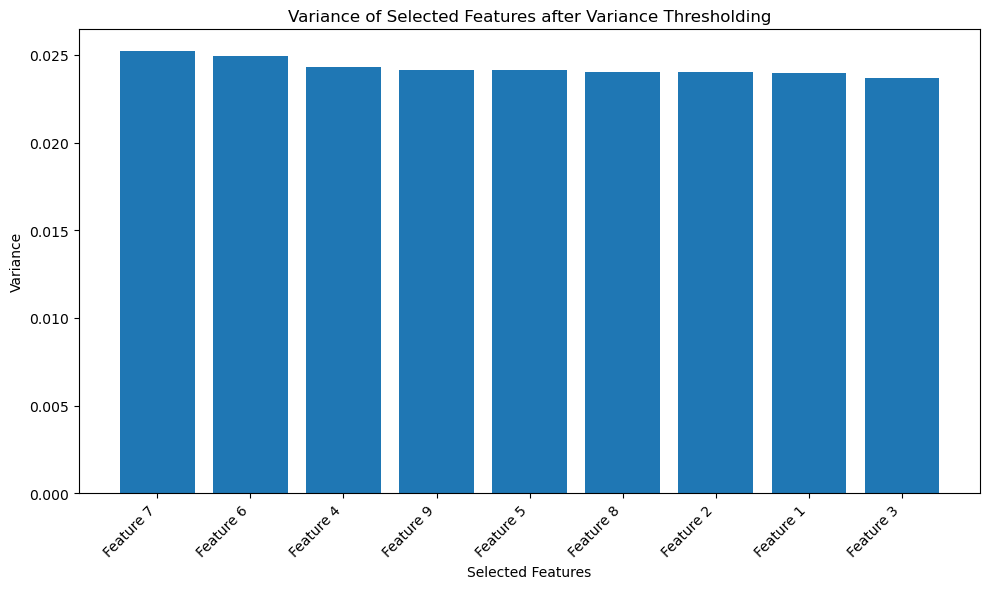

In [147]:
# Calculate variance for selected features
feature_variances = np.var(X_paa_minmax_sel, axis=0)

# Sort features based on variance and get indices
sorted_indices = np.argsort(feature_variances)[::-1]  # Descending order

# Get the names/labels of the selected features (assuming you have them)
# Replace "feature_names" with your actual feature names if available
# If not available, you can use indices as labels
feature_labels = ["Feature " + str(i+1) for i in sorted_indices]

# Get the variances of the selected features in descending order
sorted_variances = feature_variances[sorted_indices]

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(feature_labels, sorted_variances)
plt.xlabel('Selected Features')
plt.ylabel('Variance')
plt.title('Variance of Selected Features after Variance Thresholding')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


In [157]:
X_sel_df = pd.DataFrame(X_paa_minmax_sel)

In [159]:
X_sel_df['euclidean_kmeans_clusterlabels'] = X_paa_minmax_df2['euclidean_kmeans_clusterlabels2'].values

In [160]:
X_sel_df

0         1         2         3         4         5         6  \
0     0.615292  0.540674  0.477991  0.576724  0.744657  0.515127  0.632264   
1     0.236811  0.474982  0.454237  0.514955  0.503945  0.301433  0.341407   
2     0.097638  0.107765  0.115801  0.138423  0.127035  0.078992  0.088321   
3     0.371945  0.439489  0.455146  0.391210  0.405896  0.431509  0.392269   
4     0.355234  0.744557  0.460415  0.523116  0.449806  0.346448  0.317724   
...        ...       ...       ...       ...       ...       ...       ...   
9994  0.510902  0.376997  0.267015  0.425873  0.314486  0.534039  0.488250   
9995  0.065211  0.068833  0.093753  0.090108  0.086256  0.096346  0.105618   
9996  0.553811  0.423106  0.363802  0.370165  0.377241  0.439889  0.428984   
9997  0.041894  0.042090  0.045780  0.043562  0.041802  0.045791  0.049261   
9998  0.043066  0.036807  0.044770  0.046628  0.041085  0.052694  0.051227   

             7         8  euclidean_kmeans_clusterlabels  
0     0.715864  0.622407                               0  
1     0.383816  0.488514                               2  
2     0.104452  0.095580                               1  
3     0.405433  0.344451                               0  
4     0.446890  0.538974                               0  
...        ...       ...                             ...  
9994  0.520949  0.362806                               2  
9995  0.097633  0.103801                               1  
9996  0.400735  0.653517                               2  
9997  0.055766  0.046305                               1  
9998  0.050686  0.045447                               1  

[9999 rows x 10 columns]

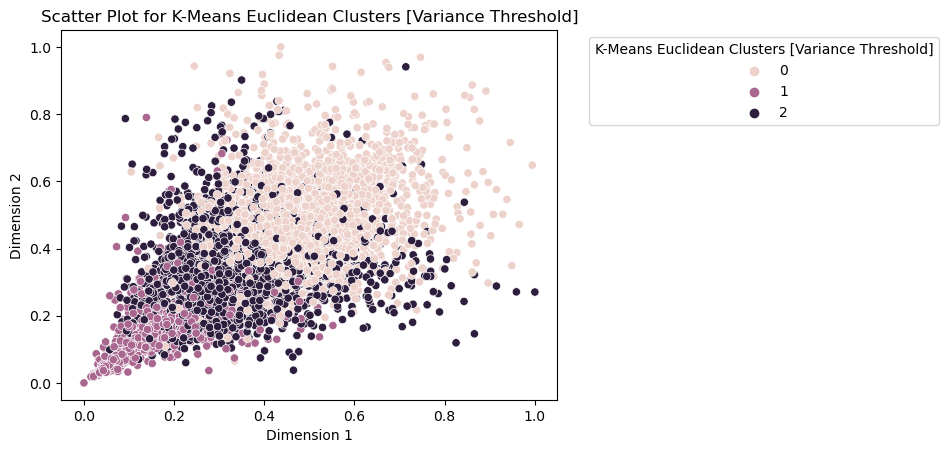

In [169]:
# Scatter plot - Euclidean Clusters
sns.scatterplot(data=X_sel_df, x=X_sel_df.iloc[:,0], y=X_sel_df.iloc[:,1], hue=X_sel_df['euclidean_kmeans_clusterlabels'])
plt.title('Scatter Plot for K-Means Euclidean Clusters [Variance Threshold]')

# Add labels for Dimension 1 and Dimension 2
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

plt.legend(title='K-Means Euclidean Clusters [Variance Threshold]', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


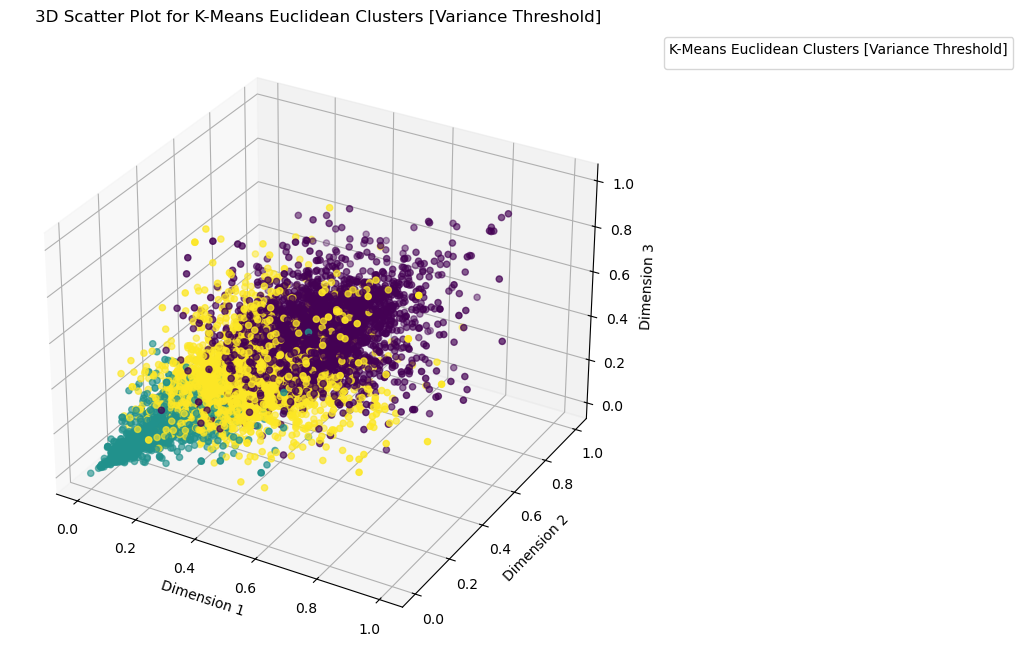

In [168]:
# Create a new figure and axis for 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot - Euclidean Clusters in 3D
ax.scatter(X_sel_df.iloc[:, 0], X_sel_df.iloc[:, 1], X_sel_df.iloc[:, 2], c=X_sel_df['euclidean_kmeans_clusterlabels'], cmap='viridis')

# Set labels and title
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
plt.title('3D Scatter Plot for K-Means Euclidean Clusters [Variance Threshold]')

# Add legend
plt.legend(title='K-Means Euclidean Clusters [Variance Threshold]', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.show()


### K=3 Best Configuration - Merging TS dataset with our pre-processed tabular dataset to gain further insights on this Clustering

In [83]:
df_tracks = pd.read_csv(r"C:\Users\rugge\Data Mining 2\df_tracks_completed.csv")

# dataset with all pre-processed steps applied

In [84]:
X_paa_minmax_df2['id'] = ids

# add "id" column to the Time Series data

In [85]:
merged_df = df_tracks.merge(X_paa_minmax_df2[['id', 'euclidean_kmeans_clusterlabels2']], on='id', how='left')

# Merge tabular data with a subset of Time Series data (w/ only "id" and cluster labels) on "id"

In [86]:
cleaned_df = merged_df.dropna(subset=['euclidean_kmeans_clusterlabels2'])

In [89]:
cleaned_df = cleaned_df.rename(columns={'euclidean_kmeans_clusterlabels2': 'euclidean_kmeans_clusterlabels'})

In [90]:
cleaned_df['euclidean_kmeans_clusterlabels'] = cleaned_df['euclidean_kmeans_clusterlabels'].astype(int)

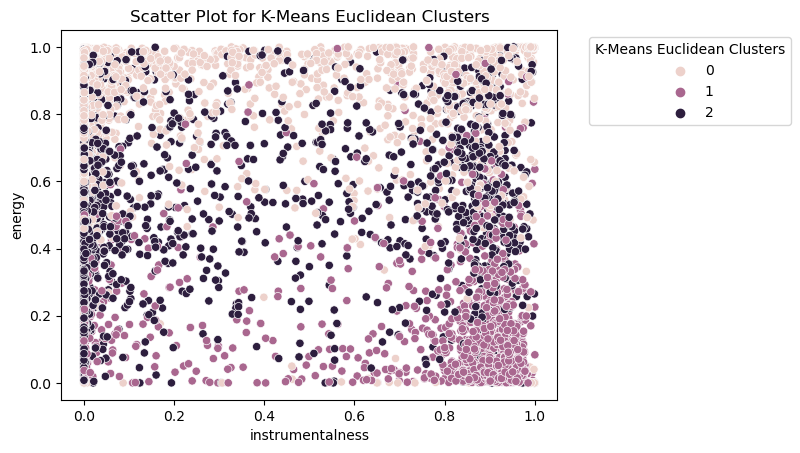

In [163]:
# Visualize the clusters resulting from Time Series dataset with two features of the tabular one

sns.scatterplot(data=cleaned_df, x='instrumentalness', y='energy', hue='euclidean_kmeans_clusterlabels')
plt.title('Scatter Plot for K-Means Euclidean Clusters')
plt.legend(title='K-Means Euclidean Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


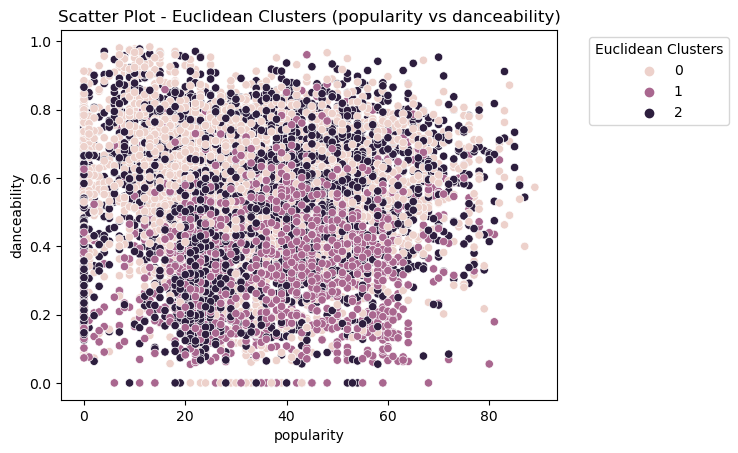

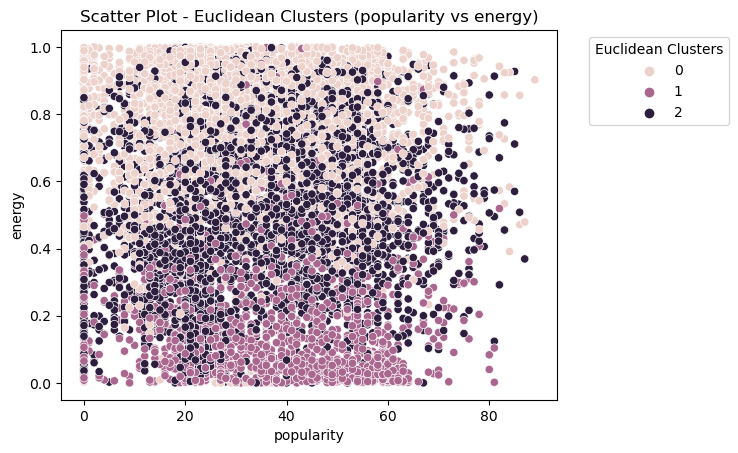

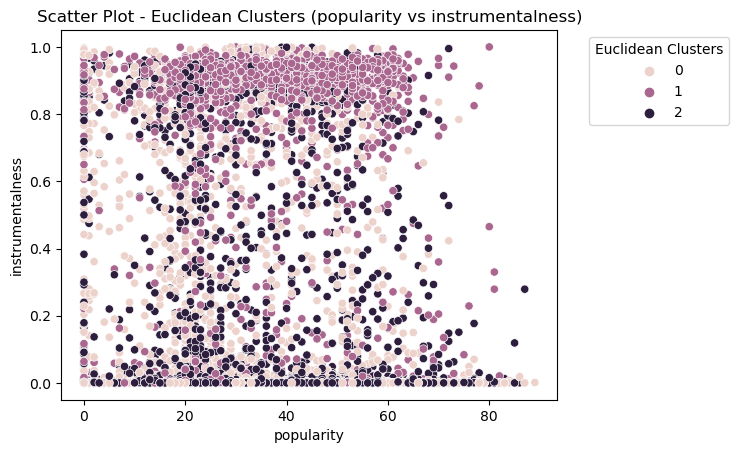

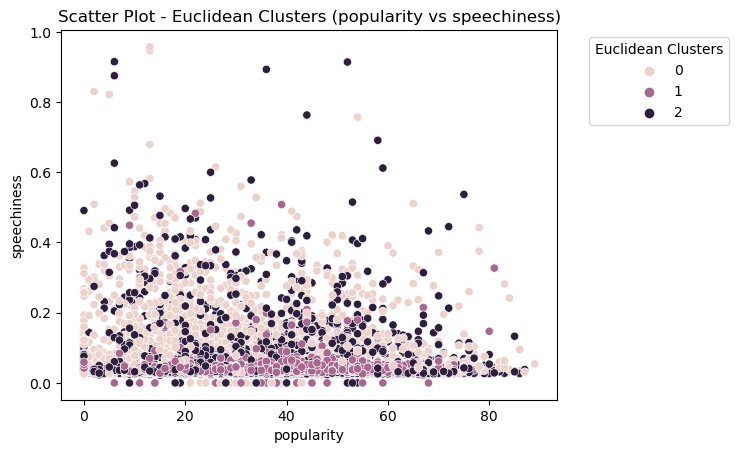

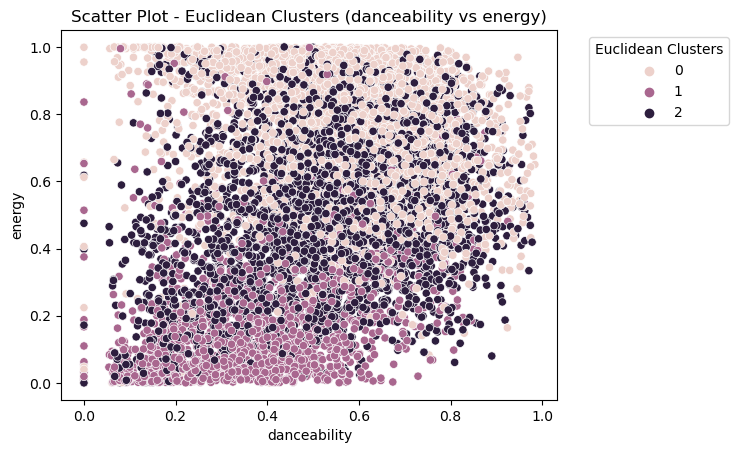

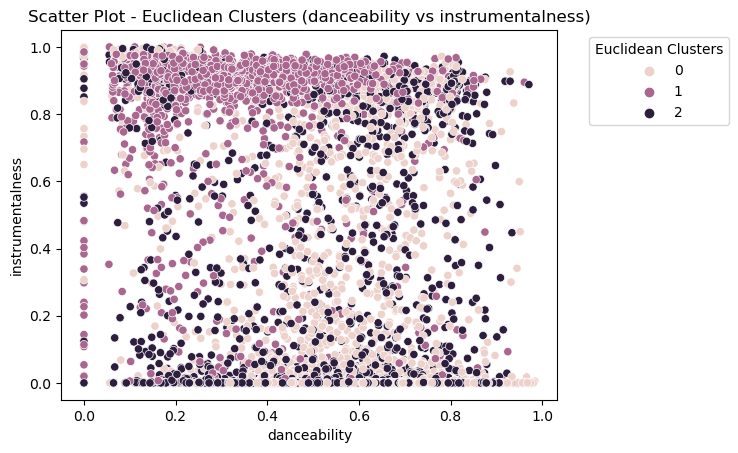

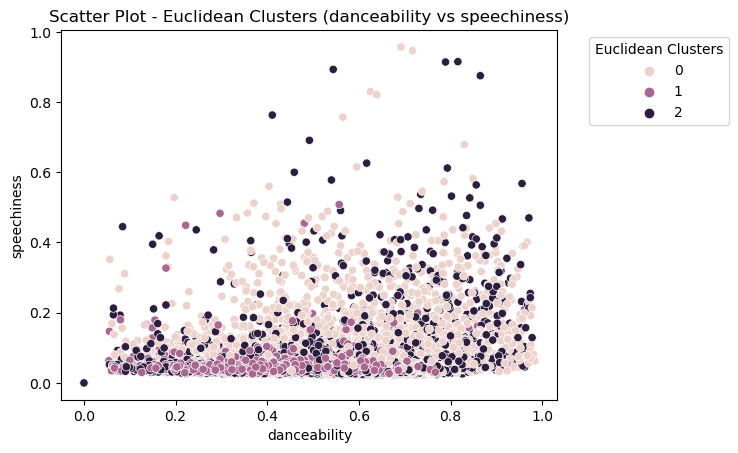

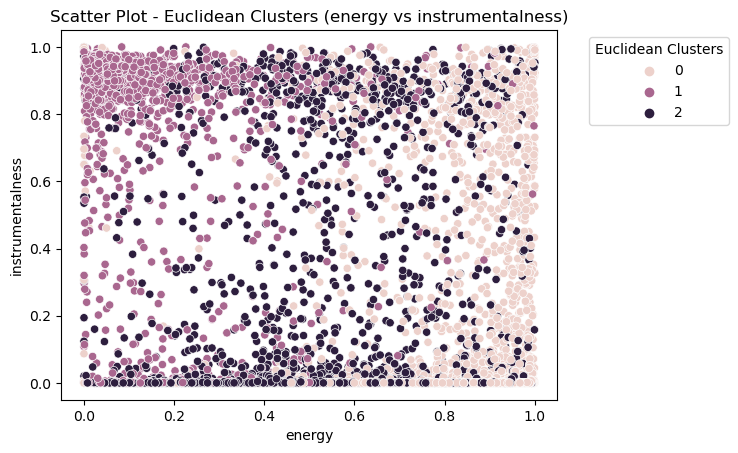

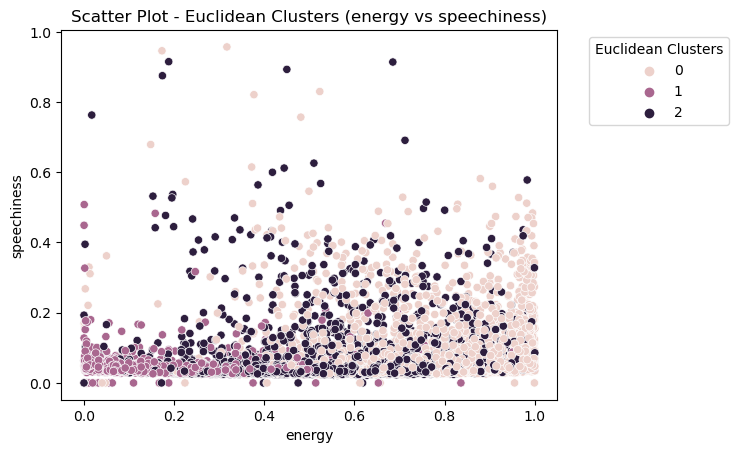

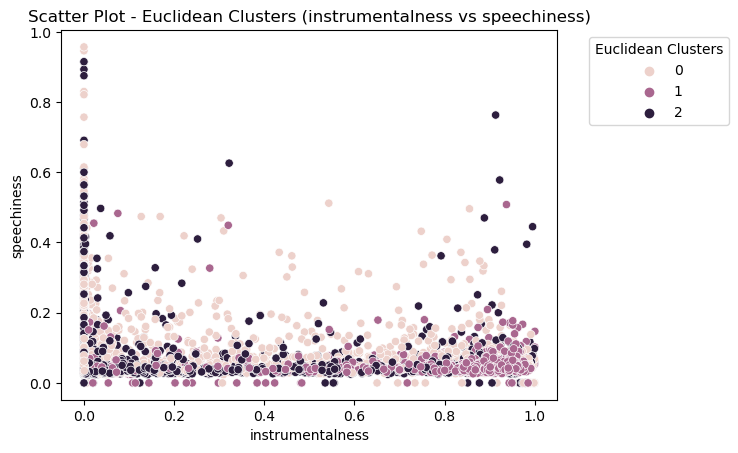

In [94]:
# Trying other pair of features for visualization

numerical_attributes = ['popularity', 'danceability', 'energy', 'instrumentalness', 'speechiness']

# Generate combinations of numerical attributes (pairs)
attribute_combinations = list(itertools.combinations(numerical_attributes, 2))

# Iterate over each pair of numerical attributes
for attr1, attr2 in attribute_combinations:
    # Scatter plot - Euclidean Clusters
    sns.scatterplot(data=cleaned_df, x=attr1, y=attr2, hue='euclidean_kmeans_clusterlabels')
    plt.title(f'Scatter Plot - Euclidean Clusters ({attr1} vs {attr2})')
    plt.legend(title='Euclidean Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

### DTW K-Means (K=3 best configuration)

C:\Users\rugge\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\rugge\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\rugge\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\rugge\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\rugge\anaconda3\Lib\site-packages\sklearn\clust

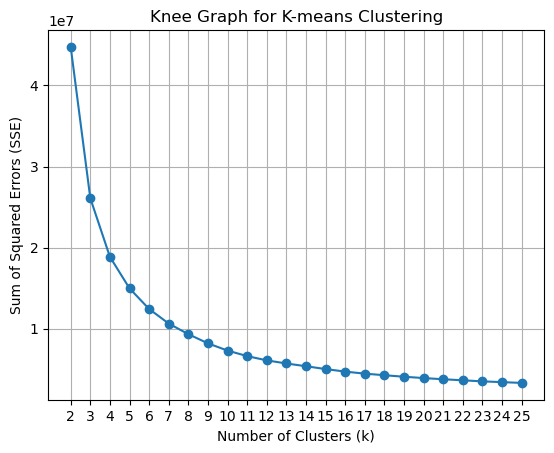

In [88]:
# Define the range of clusters
k_values = range(2, 26)

# Initialize an empty list to store the SSE for each cluster
sse = []

# Iterate over each value of k
for k in k_values:
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    # Fit K-means clustering using the precomputed distance matrix
    kmeans.fit_predict(distance_df_minmax)
    # Append the SSE to the list
    sse.append(kmeans.inertia_)

# Plot the knee graph
plt.plot(k_values, sse, marker='o', linestyle='-')
plt.title('Knee Graph for K-means Clustering')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.xticks(np.arange(2, 26, step=1))
plt.grid(True)
plt.show()

In [170]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
# Fit K-means clustering using the precomputed distance matrix
kmeans.fit(distance_df_minmax)

# Get cluster labels for each data point
cluster_labels = kmeans.labels_

C:\Users\rugge\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [171]:
X_paa_minmax_df['dtw_kmeans_clusterlabels'] = cluster_labels

# Same steps of Euclidean K-Means will follow

C:\Users\rugge\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\rugge\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


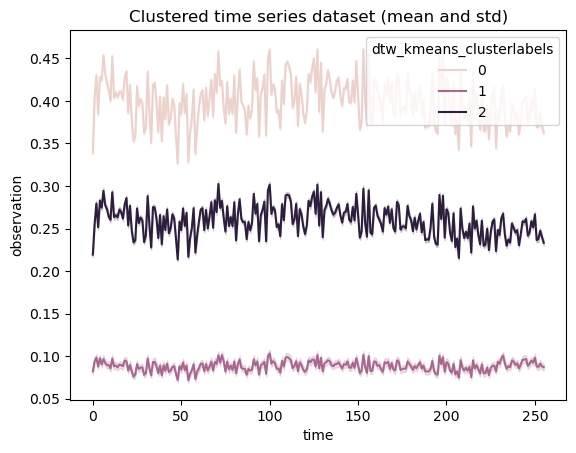

In [174]:
# Remove the 257th feature temporarily for visualization, which is the other cluster labels.
X_paa_minmax_df_subset = X_paa_minmax_df.drop(X_paa_minmax_df.columns[[256, 257]], axis=1)

# Melt the dataframe to convert it to long format
df_melt2 = X_paa_minmax_df_subset.melt(value_name="observation", var_name="time", id_vars="dtw_kmeans_clusterlabels")

# Create a line plot
sns.lineplot(data=df_melt2, x="time", y="observation", hue="dtw_kmeans_clusterlabels")

# Set plot title
plt.title("Clustered time series dataset (mean and std)")

# Show the plot
plt.show()

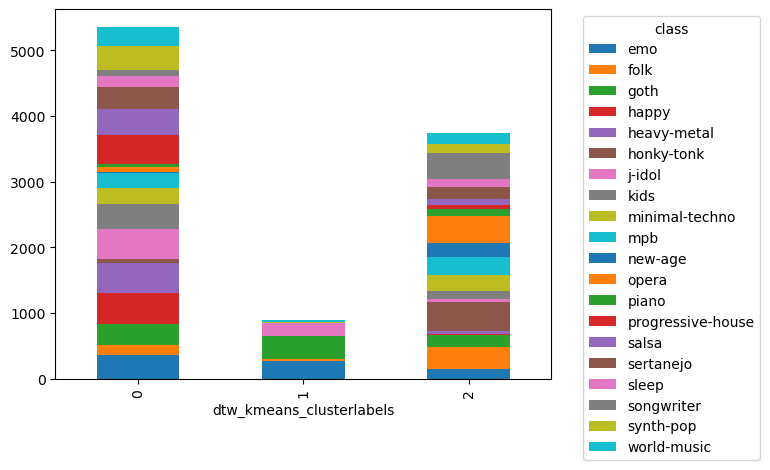

In [177]:
ax = pd.crosstab(X_paa_minmax_df_subset["dtw_kmeans_clusterlabels"], y).plot(kind="bar", stacked=True)
plt.legend(title="class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



In [178]:
# Cluster 1 insights

# Filter the DataFrame where 'euclidean_kmeans_clusterlabels' == 1
minmax_filtered_df3 = X_paa_minmax_df_subset[X_paa_minmax_df_subset["dtw_kmeans_clusterlabels"] == 1]

# Get the indices of the filtered DataFrame
filtered_indices = minmax_filtered_df3.index

# Filter y based on the indices
y_filtered = y[filtered_indices]

# Convert y_filtered to a pandas Series
y_series = pd.Series(y_filtered, index=filtered_indices)

# Count the occurrences of each genre in the filtered DataFrame based on y
count_values = y_series.value_counts()

print('Cluster1:\n')
count_values

### Very discriminative, only slow songs

Cluster1:



piano             352
new-age           261
sleep             209
world-music        44
opera              19
honky-tonk          4
emo                 3
minimal-techno      2
goth                2
synth-pop           2
songwriter          1
folk                1
Name: count, dtype: int64

In [194]:
silhouette_avg = silhouette_score(X_paa_minmax_df_subset.iloc[:,:256], X_paa_minmax_df_subset["dtw_kmeans_clusterlabels"])

# Print the silhouette score
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.2634732072197363


In [182]:
# Filter the DataFrame where 'euclidean_kmeans_clusterlabels' == 0
minmax_filtered_df3 = X_paa_minmax_df_subset[X_paa_minmax_df_subset["dtw_kmeans_clusterlabels"] == 0]

# Get the indices of the filtered DataFrame
filtered_indices = minmax_filtered_df3.index

# Filter y based on the indices
y_filtered = y[filtered_indices]

# Convert y_filtered to a pandas Series
y_series = pd.Series(y_filtered, index=filtered_indices)

# Count the occurrences of each genre in the filtered DataFrame based on y
count_values = y_series.value_counts()

print('Cluster0:\n')
count_values

### Mainly active songs. Will not go on with further analysis with DTW because Euclidean was deemed better, more info on the report.

Cluster0:



happy                482
j-idol               464
heavy-metal          456
progressive-house    431
salsa                407
kids                 377
synth-pop            363
emo                  355
sertanejo            326
goth                 318
world-music          290
minimal-techno       245
mpb                  224
sleep                170
folk                 155
songwriter            98
opera                 74
honky-tonk            53
piano                 48
new-age               24
Name: count, dtype: int64

### Hierarchical Clustering

In [10]:
# Condense the DTW distance matrix
condensed_distance_matrix = squareform(distance_df_minmax)

In [ ]:
##### Single Linkage mainly comprised singletons, not suitable

##### Complete Linkage

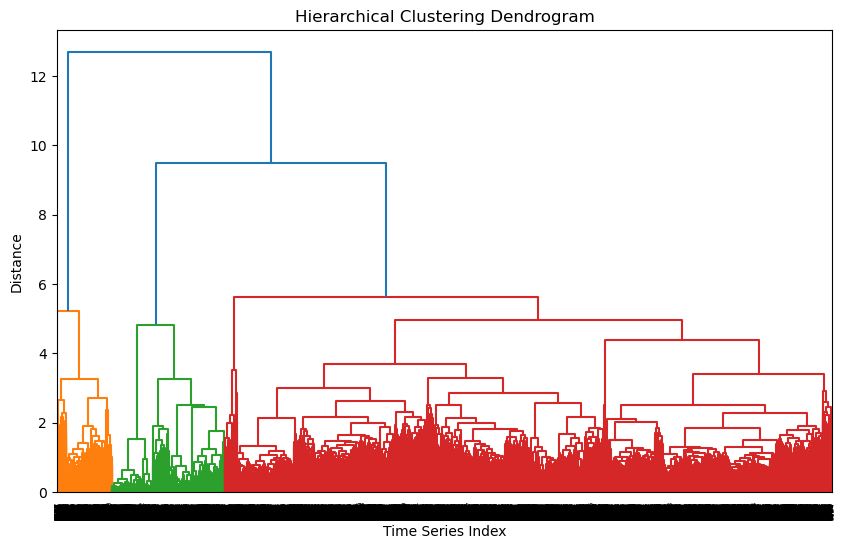

In [13]:
# Perform hierarchical clustering using precomputed distances
Z_complete = linkage(condensed_distance_matrix, method='complete')  # Change method if needed

# Plot dendrogram
plt.figure(figsize=(10, 6))
dendrogram(Z_complete)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Time Series Index')
plt.ylabel('Distance')
plt.show()

In [25]:
# maxclust = 3 seems a reasonable cut 
maxclust=3
clusters_complete = fcluster(Z_complete, maxclust, criterion='maxclust')

# Compute silhouette score for average linkage
silhouette_complete = silhouette_score(distance_df_minmax, clusters_complete, metric='precomputed')

In [26]:
silhouette_complete

0.26830799610386435

In [27]:
# Compute cluster sizes
cluster_sizes = np.bincount(clusters_complete)

# Print cluster sizes
for cluster_id, size in enumerate(cluster_sizes[1:], 1):
    print(f"Cluster {cluster_id}: {size} points")

Cluster 1: 710 points
Cluster 2: 1458 points
Cluster 3: 7831 points


In [30]:
X_paa_minmax_df_hierarchical = pd.DataFrame(X_paa_minmax)
X_paa_minmax_df_hierarchical['cluster'] = clusters_complete

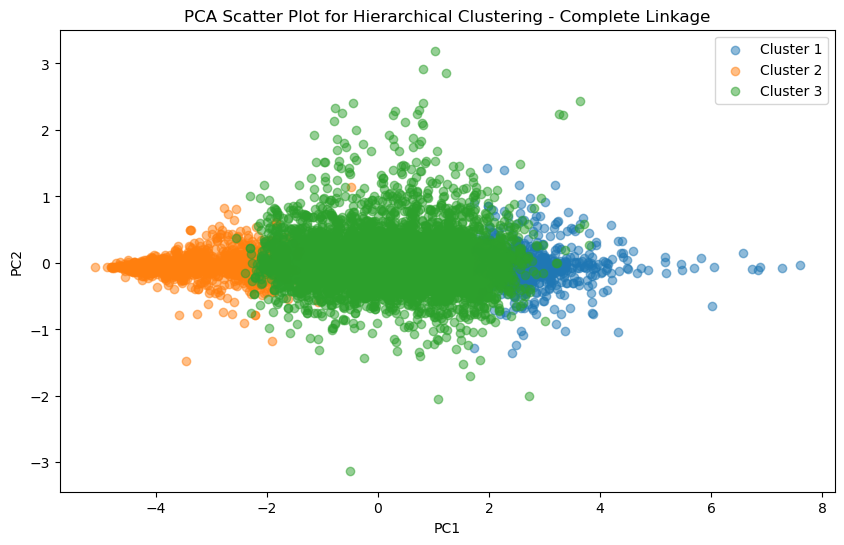

In [34]:
pca_df['hierarchical_complete_clusters'] = X_paa_minmax_df_hierarchical['cluster'].values

# Plot PCA scatter plot for Euclidean clusters
plt.figure(figsize=(10, 6))
for label in np.unique(pca_df['hierarchical_complete_clusters']):
    plt.scatter(pca_df.loc[pca_df['hierarchical_complete_clusters'] == label, 'PC1'],
                pca_df.loc[pca_df['hierarchical_complete_clusters'] == label, 'PC2'],
                label=f'Cluster {label}', alpha=0.5)
plt.title('PCA Scatter Plot for Hierarchical Clustering - Complete Linkage')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()


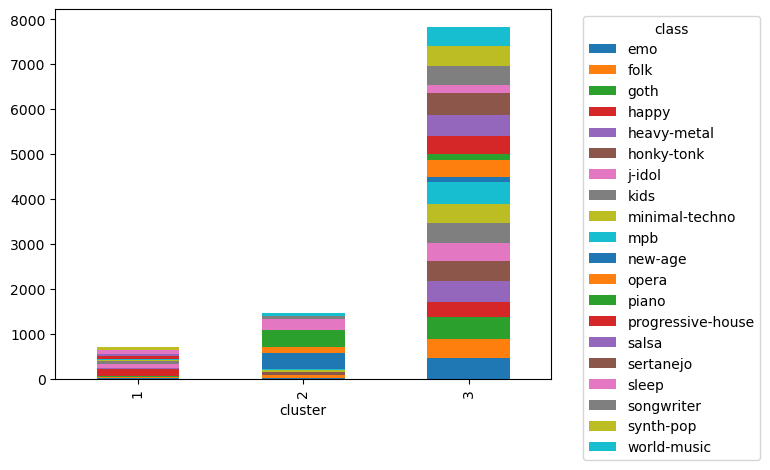

In [35]:
ax = pd.crosstab(X_paa_minmax_df_hierarchical['cluster'], y).plot(kind="bar", stacked=True)
plt.legend(title="class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [41]:
### Next try: maxclust = 8, also reasonable 
maxclust=8
clusters_complete = fcluster(Z_complete, maxclust, criterion='maxclust')

# Compute silhouette score for average linkage
silhouette_complete = silhouette_score(distance_df_minmax, clusters_complete, metric='precomputed')

In [42]:
silhouette_complete

0.13844672136994826

In [43]:
# Compute cluster sizes
cluster_sizes = np.bincount(clusters_complete)

# Print cluster sizes
for cluster_id, size in enumerate(cluster_sizes[1:], 1):
    print(f"Cluster {cluster_id}: {size} points")

Cluster 1: 13 points
Cluster 2: 697 points
Cluster 3: 529 points
Cluster 4: 929 points
Cluster 5: 152 points
Cluster 6: 4741 points
Cluster 7: 20 points
Cluster 8: 2918 points


In [ ]:
##### Also Average Linkage results were very poor

#### Density-based Custering: DBSCAN

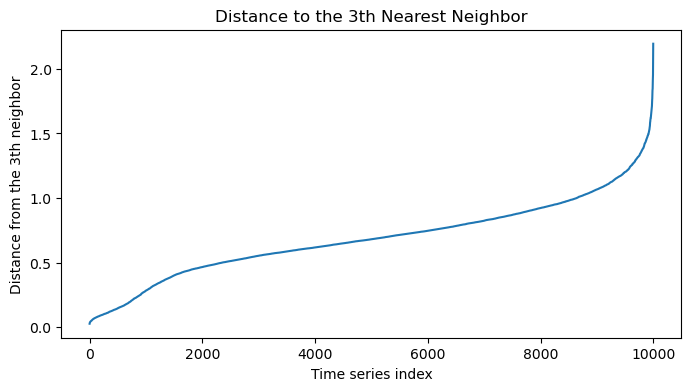

In [46]:
# Define the value of k
k = 3

kth_distances = []

for index, row in distance_df_minmax.iterrows():  # Iterate over each row of the distance matrix
    sorted_d = np.sort(row.values)  # Sort the distances in the row
    kth_distances.append(sorted_d[k])  # Store the distance of the k-th nearest neighbor

plt.figure(figsize=(8, 4))
plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.ylabel('Distance from the {}th neighbor'.format(k))
plt.xlabel('Time series index')
plt.title('Distance to the {}th Nearest Neighbor'.format(k))
plt.show()


In [47]:
dbscan = DBSCAN(eps=1.25, min_samples=3, metric='precomputed')
dbscan.fit(distance_df_minmax)

DBSCAN(eps=1.25, metric='precomputed', min_samples=3)

In [48]:
np.unique(dbscan.labels_, return_counts=True)

# After trying different configurations, no result is satisfying

(array([-1,  0], dtype=int64), array([ 330, 9669], dtype=int64))

## Classification

### KNN with Euclidean Distance (Predicting Cluster Labels)

In [93]:
# Step 1: Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_paa_standard, clusterer.labels_, test_size=0.0999, random_state=42)

Best number of neighbors: 19
Best cross-validated accuracy: 0.9792222222222223


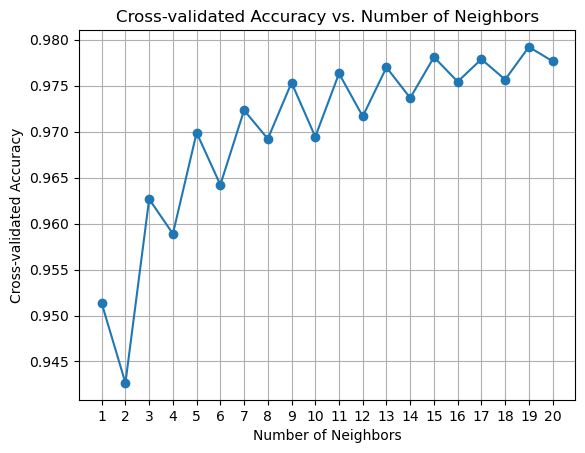

In [96]:
# Define number of neighbors to try
neighbors = list(range(1, 21))

# Define KFold cross-validator with 3 folds
kfold = KFold(n_splits=3)

# Initialize variables to store results
best_accuracy = 0
best_k = None
avg_accuracies = []

# Loop over different values of k
for k in neighbors:
    accuracies = []
    fold_num = 1
    # Loop over different splits of the data
    for train_index, val_index in kfold.split(X_train):
        # Split data into training and validation sets
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        
        # Train KNN classifier
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train_fold, y_train_fold)
        
        # Predict on validation set
        y_pred = knn.predict(X_val_fold)
        
        # Compute accuracy
        accuracy = accuracy_score(y_val_fold, y_pred)
        accuracies.append(accuracy)
        
        # Classification report for this fold
        if k == best_k and fold_num == 3:
            print("Classification Report for KNN with k =", k, "and fold", fold_num)
            report = classification_report(y_val_fold, y_pred)
            print(report)
        
        fold_num += 1
    
    # Average accuracy across folds
    avg_accuracy = np.mean(accuracies)
    avg_accuracies.append(avg_accuracy)
    
    # Check if this value of k gives better accuracy
    if avg_accuracy > best_accuracy:
        best_accuracy = avg_accuracy
        best_k = k

print("Best number of neighbors:", best_k)
print("Best cross-validated accuracy:", best_accuracy)

# Plotting the results
plt.plot(neighbors, avg_accuracies, marker='o')
plt.title('Cross-validated Accuracy vs. Number of Neighbors')
plt.xlabel('Number of Neighbors')
plt.ylabel('Cross-validated Accuracy')
plt.xticks(neighbors)
plt.grid(True)
plt.show()


In [97]:
# Set K to 3 for the previous graph 
k = 3

# Define KFold cross-validator with 3 folds
kfold = KFold(n_splits=3)

# Loop over different splits of the data
for fold_num, (train_index, val_index) in enumerate(kfold.split(X_train), start=1):
    # Split data into training and validation sets
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # Train KNN classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_fold, y_train_fold)
    
    # Predict on validation set
    y_pred = knn.predict(X_val_fold)
    
    # Classification report for this fold
    print("Classification Report for fold", fold_num)
    report = classification_report(y_val_fold, y_pred)
    print(report)


Classification Report for fold 1
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1258
           1       0.95      0.97      0.96       467
           2       0.97      0.94      0.95      1275

    accuracy                           0.96      3000
   macro avg       0.96      0.96      0.96      3000
weighted avg       0.96      0.96      0.96      3000

Classification Report for fold 2
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      1297
           1       0.96      0.98      0.97       464
           2       0.97      0.93      0.95      1239

    accuracy                           0.96      3000
   macro avg       0.96      0.96      0.96      3000
weighted avg       0.96      0.96      0.96      3000

Classification Report for fold 3
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1272
           1       0.95      0

In [98]:
# Set K to 3
k = 3

# Train KNN classifier on the entire training set (X_train)
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

# Predict on the test set (X_test)
y_pred_test = knn.predict(X_test)

# Classification report for the test set
report = classification_report(y_test, y_pred_test)
print("Classification Report for Test Set:")
print(report)


Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       429
           1       0.95      0.99      0.97       160
           2       0.96      0.94      0.95       410

    accuracy                           0.96       999
   macro avg       0.96      0.97      0.96       999
weighted avg       0.96      0.96      0.96       999



### KNN with Euclidean Distance (Predicting 20 genres)

In [86]:
# Train KNN classifier on the entire training set
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

# Predict on the test set
y_pred_test = knn.predict(X_test)

# Evaluate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_pred_test)

print("Test set accuracy:", test_accuracy)


from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_test, y_pred_test)

print("Classification Report:")
print(report)

# Very poor results

Test set accuracy: 0.1282565130260521
Classification Report:
                   precision    recall  f1-score   support

              emo       0.08      0.04      0.05        25
             folk       0.31      0.17      0.22        30
             goth       0.03      0.04      0.03        25
            happy       0.22      0.30      0.25        23
      heavy-metal       0.03      0.05      0.03        22
       honky-tonk       0.60      0.12      0.21        24
           j-idol       0.07      0.04      0.05        25
             kids       0.00      0.00      0.00        26
   minimal-techno       0.58      0.27      0.37        26
              mpb       0.00      0.00      0.00        24
          new-age       0.16      0.27      0.20        22
            opera       0.19      0.21      0.20        19
            piano       0.50      0.12      0.19        25
progressive-house       0.57      0.20      0.30        20
            salsa       0.00      0.00      0.00     

C:\Users\rugge\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rugge\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rugge\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### KNN with DTW (Predicting 20 genres)

In [61]:
### K=2 chosen after much trial and error

# Initialize K-Fold cross-validator with K=3
kf = KFold(n_splits=3)

# List to store cross-validation scores for each fold
fold_scores = []

# Perform cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X_train)):
    # Split data into training and test sets
    X_fold_train, X_fold_test = X_train[train_index], X_train[test_index]
    y_fold_train, y_fold_test = y_train[train_index], y_train[test_index]

    # Initialize the classifier with n_neighbors=2
    clf = KNeighborsClassifier(n_neighbors=2)

    # Train the classifier
    clf.fit(X_fold_train, y_fold_train)

    # Evaluate the classifier
    accuracy = clf.score(X_fold_test, y_fold_test)
    fold_scores.append(accuracy)

# Compute the mean accuracy across all folds
mean_accuracy = sum(fold_scores) / len(fold_scores)

# Train the KNN classifier with n_neighbors=2
clf = KNeighborsClassifier(n_neighbors=2)
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print mean cross-validation accuracy
print("Mean Cross-Validation Accuracy:", mean_accuracy)

# Poor results

Classification Report:
                   precision    recall  f1-score   support

              emo       0.05      0.02      0.03        46
             folk       0.28      0.12      0.17        57
             goth       0.02      0.02      0.02        44
            happy       0.24      0.27      0.25        59
      heavy-metal       0.01      0.02      0.02        41
       honky-tonk       0.32      0.13      0.19        45
           j-idol       0.12      0.09      0.10        46
             kids       1.00      0.02      0.04        55
   minimal-techno       0.62      0.34      0.44        53
              mpb       0.00      0.00      0.00        49
          new-age       0.17      0.26      0.21        54
            opera       0.16      0.17      0.17        40
            piano       0.42      0.16      0.24        49
progressive-house       0.41      0.15      0.22        47
            salsa       0.00      0.00      0.00        55
        sertanejo       0.00    

C:\Users\rugge\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rugge\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rugge\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### KNN with DTW (Predicting Cluster labels)

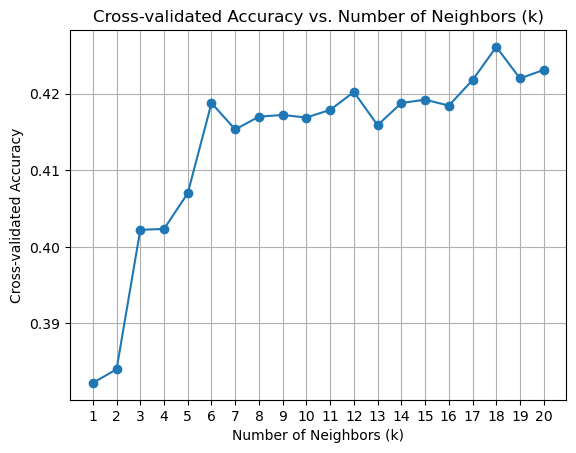

In [101]:
# Define KFold cross-validator with 3 folds
kfold = KFold(n_splits=3)

# Define range of values for k
k_values = range(1, 21)

# Initialize list to store average accuracies
avg_accuracies = []

# Loop over different values of k
for k in k_values:
    fold_accuracies = []
    # Loop over different splits of the data
    for train_index, val_index in kfold.split(X_train):
        # Use precomputed DTW distance matrix for training fold
        X_train_dtw = distance_df_standard.iloc[train_index, train_index].values
        X_val_dtw = distance_df_standard.iloc[val_index, train_index].values
        
        # Split data into training and validation sets
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        
        # Train KNN classifier with precomputed DTW distances
        knn = KNeighborsClassifier(n_neighbors=k, metric='precomputed')
        knn.fit(X_train_dtw, y_train_fold)
        
        # Predict on validation set
        y_pred = knn.predict(X_val_dtw)
        
        # Compute accuracy for this fold
        fold_accuracy = accuracy_score(y_val_fold, y_pred)
        fold_accuracies.append(fold_accuracy)
    
    # Average accuracy across folds
    avg_accuracy = np.mean(fold_accuracies)
    avg_accuracies.append(avg_accuracy)

# Plotting the knee graph
plt.plot(k_values, avg_accuracies, marker='o')
plt.title('Cross-validated Accuracy vs. Number of Neighbors (k)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-validated Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.show()


In [102]:
# Define KFold cross-validator with 3 folds
kfold = KFold(n_splits=3)

# Set k to 6
k = 6

# Loop over different splits of the data
for fold_num, (train_index, val_index) in enumerate(kfold.split(X_train), start=1):
    # Split data into training and validation sets
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # Use precomputed DTW distance matrix for training fold
    X_train_dtw = distance_df_standard.iloc[train_index, train_index].values
    
    # Train KNN classifier with precomputed DTW distances
    knn = KNeighborsClassifier(n_neighbors=k, metric='precomputed')
    knn.fit(X_train_dtw, y_train_fold)
    
    # Use precomputed DTW distance matrix for validation fold
    X_val_dtw = distance_df_standard.iloc[val_index, train_index].values
    
    # Predict on validation set
    y_pred = knn.predict(X_val_dtw)
    
    # Classification report for this fold
    print("Classification Report for fold", fold_num, "with k =", k)
    report = classification_report(y_val_fold, y_pred)
    print(report)


Classification Report for fold 1 with k = 6
              precision    recall  f1-score   support

           0       0.42      0.58      0.49      1258
           1       0.20      0.06      0.09       467
           2       0.44      0.40      0.42      1275

    accuracy                           0.42      3000
   macro avg       0.35      0.34      0.33      3000
weighted avg       0.40      0.42      0.40      3000

Classification Report for fold 2 with k = 6
              precision    recall  f1-score   support

           0       0.44      0.54      0.49      1297
           1       0.20      0.05      0.08       464
           2       0.42      0.44      0.43      1239

    accuracy                           0.42      3000
   macro avg       0.36      0.35      0.34      3000
weighted avg       0.40      0.42      0.40      3000

Classification Report for fold 3 with k = 6
              precision    recall  f1-score   support

           0       0.42      0.59      0.49      12

In [117]:
# Set k to 6
k = 6

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

# Use precomputed DTW distance matrix for training set
X_train_dtw = distance_df_standard.iloc[X_train.index, X_train.index].values

# Train KNN classifier with precomputed DTW distances
knn = KNeighborsClassifier(n_neighbors=k, metric='precomputed')
knn.fit(X_train_dtw, y_train)

# Use precomputed DTW distance matrix for testing set
X_test_dtw = distance_df_standard.iloc[X_test.index, X_train.index].values

# Predict on test set
y_pred = knn.predict(X_test_dtw)

# Classification report for the test set
print("Classification Report for the test set with k =", k)
report = classification_report(y_test, y_pred)
print(report)

# Much worse performance comapared to Euclidean KNN on the same task

Classification Report for the test set with k = 6
              precision    recall  f1-score   support

           0       0.44      0.58      0.50       429
           1       0.22      0.06      0.09       160
           2       0.43      0.40      0.42       410

    accuracy                           0.43       999
   macro avg       0.36      0.35      0.34       999
weighted avg       0.40      0.43      0.40       999

